# F1 EDA
#### PART 2: 

Here I answer some questions regarding pit stops and compounds.

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "https://i.giphy.com/media/v1.Y2lkPTc5MGI3NjExMmhzN3JpeGU1d2VuZWoyMXZzcDNkNTd1OXo2cHo2M3E1czBpMnE2eSZlcD12MV9pbnRlcm5hbF9naWZfYnlfaWQmY3Q9Zw/lpWpTgxk9cN8vDt75T/giphy.gif")

## 1) Importing Packages and Data

In [2]:
import pandas as pd
import numpy as np
import F1_Preprocessing #Internal package to preprocess data
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

np.random.seed(1994)
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True)
plt.figure(dpi=150)
warnings.filterwarnings('ignore', category=FutureWarning)

<Figure size 960x720 with 0 Axes>

In [3]:
#The data stored in this path is obtained from ERGAST AND FASTF1 APIs (The files used to update and download the data are in the repo)

path = 'C:/Users/gabri/Dropbox/Gaby/Proyectos/My_Portafolio/F1/Data/'

PitsDF=pd.read_csv(path+"PitsDF.csv")
ResultsDF=pd.read_csv(path+"ResultsDF.csv")
WeatherDF=pd.read_csv(path+"FASTF1_Weather.csv") #available only from 2018
LapsDF=pd.read_csv(path+"FASTF1_Laps.csv") #FAST F1 available only from 2018, Ergast from before but does not have compound data

C:\Users\gabri\AppData\Local\Temp\ipykernel_39452\3773281892.py:8: DtypeWarning: Columns (27,28) have mixed types. Specify dtype option on import or set low_memory=False.
  LapsDF=pd.read_csv(path+"FASTF1_Laps.csv") #FAST F1 available only from 2018, Ergast from before but does not have compound data


## 2) Data Preprocessing

In [4]:
# Apply the data preprocessing for each df using a function stored in the repo from F1_Preprocessing.py 
# This is done this way so the preprocessing is consistent throughout all notebooks.
# With this code we:
#   - create new features
#   - format dates and floats
#   - encode features
#   - null handling

ResultsDF=F1_Preprocessing.preprocess_Ergast_Results(ResultsDF,OneHotEncoder=True,HandleNulls=True)
PitsDF=F1_Preprocessing.preprocess_Ergast_Pits(PitsDF,OneHotEncoder=True)
WeatherDF=F1_Preprocessing.preprocess_FastF1_Weather(WeatherDF,OneHotEncoder=True)
LapsDF=F1_Preprocessing.preprocess_FastF1_Laps(LapsDF,OneHotEncoder=True)

from_season=2018

ResultsDF=ResultsDF[ResultsDF["season"]>=from_season]
PitsDF=PitsDF[PitsDF["season"]>=from_season]
WeatherDF=WeatherDF[WeatherDF["season"]>=from_season]
LapsDF=LapsDF[LapsDF["season"]>=from_season]

print(len(ResultsDF))
print(len(PitsDF))
print(len(WeatherDF))
print(len(LapsDF))

2879
3861
70243
392595


In [5]:
#making a df with the pits in a season-round-driver level
#Deleting 7 rows where the number of pit stops is higher than 5
columns_from_original=PitsDF.drop(columns=["pit_stop_duration_in_milliseconds","pit_stop_number","pit_stop_lap_number",'pit_stop_time', 'pit_stop_duration']).columns
PitsDF=PitsDF[PitsDF["pit_stop_number"]<=5]

DF_CALCULATED=PitsDF.groupby(["season-round-driverid"]).agg(Total_Num_Pits=("pit_stop_number","max"),
                                              Total_Duration_Pits_milliseconds=("pit_stop_duration_in_milliseconds","sum"),
                                              Min_Duration_Pits_milliseconds=("pit_stop_duration_in_milliseconds","min"),
                                              Avg_Duration_Pits_milliseconds=("pit_stop_duration_in_milliseconds","mean"),
                                              Max_Duration_Pits_milliseconds=("pit_stop_duration_in_milliseconds","max"),
                                              Avg_PitStop_Lap_number=("pit_stop_lap_number","mean"),
                                              Min_PitStop_Lap_number=("pit_stop_lap_number","min"),
                                              Max_PitStop_Lap_number=("pit_stop_lap_number","max")).reset_index()

DF_PIVOT=PitsDF.pivot(index="season-round-driverid",columns=["pit_stop_number"],values=["pit_stop_lap_number","pit_stop_duration_in_milliseconds"]).reset_index()
DF_PIVOT.columns = ['_'.join(map(str, col)).strip() if isinstance(col, tuple) else col for col in DF_PIVOT.columns]
DF_PIVOT=DF_PIVOT.rename(columns={"season-round-driverid_":"season-round-driverid"})

PitsDF_RACE_DRIVER_LEVEL=DF_CALCULATED.merge(DF_PIVOT,on="season-round-driverid",how="left").merge(PitsDF[columns_from_original].drop_duplicates(),how="left")
print(len(PitsDF_RACE_DRIVER_LEVEL))


2685


In [6]:
####################################################################################################
#Prepare weather data at the start of the race to add to PitsDF_RACE_DRIVER_LEVEL df. 
print(WeatherDF["season-round"].nunique())
WeatherDF_StartRace=WeatherDF[(WeatherDF["event_Race"]==1)].groupby(["season-round"]).agg(MinTime=("time","min")).reset_index()
WeatherDF_StartRace=WeatherDF_StartRace.merge(WeatherDF[['time', 'airtemp', 'humidity', 'pressure', 'rainfall', 'tracktemp',
                                                         'winddirection', 'windspeed', 'season-round',
                                                         'season-round-event', 'normalized_airtemp', 'normalized_humidity',
                                                         'normalized_pressure', 'normalized_rainfall', 'normalized_tracktemp',
                                                         'normalized_winddirection', 'normalized_windspeed']],
                                                         on="season-round",how="right")
WeatherDF_StartRace=WeatherDF_StartRace[WeatherDF_StartRace["MinTime"]==WeatherDF_StartRace["time"]].drop(columns=["MinTime",'time'])
print(len(WeatherDF_StartRace))

####################################################################################################
#Prepare compound data at the start of the race to add to PitsDF_RACE_DRIVER_LEVEL df. 
print(len(LapsDF[["season-round","driver"]].drop_duplicates()))
Compounds_StartRace=LapsDF[(LapsDF["event_Race"]==1)].groupby(["season-round","driver"]).agg(MinTime=("time","min")).reset_index()
Compounds_StartRace=Compounds_StartRace.merge(LapsDF[['time','driver', 'drivernumber','tyrelife', 'freshtyre','season-round', 'normalized_tyrelife', 'compound_cat',
                                                         'compound_HARD', 'compound_HYPERSOFT', 'compound_INTERMEDIATE',
                                                         'compound_MEDIUM', 'compound_SOFT', 'compound_SUPERSOFT',
                                                         'compound_TEST-UNKNOWN', 'compound_ULTRASOFT', 'compound_WET','compound', 'event']],
                                                         on=["season-round","driver"],how="right")
Compounds_StartRace=Compounds_StartRace[Compounds_StartRace["MinTime"]==Compounds_StartRace["time"]].drop(columns=["MinTime",'time'])
print(len(Compounds_StartRace))

####################################################################################################
#Prepare Results data to add to PitsDF_RACE_DRIVER_LEVEL df.
selected_features_constructor_focused=ResultsDF.loc[:, ResultsDF.columns.str.startswith("constructor.constructorid_")].columns.to_list()
selected_features_extra=["driver.code","constructor.name","driver.age_at_race","season-round-driverid"]
ResultsDF_to_pits=ResultsDF[selected_features_extra+selected_features_constructor_focused]
print(len(ResultsDF_to_pits))

####################################################################################################
#Merge with main df
PitsDF_RACE_DRIVER_LEVEL=PitsDF_RACE_DRIVER_LEVEL.merge(ResultsDF_to_pits,on="season-round-driverid",how="left")
print(len(PitsDF_RACE_DRIVER_LEVEL))

PitsDF_RACE_DRIVER_LEVEL=PitsDF_RACE_DRIVER_LEVEL.merge(WeatherDF_StartRace,on="season-round",how="left")
print(len(PitsDF_RACE_DRIVER_LEVEL))

PitsDF_RACE_DRIVER_LEVEL=PitsDF_RACE_DRIVER_LEVEL.merge(Compounds_StartRace,left_on=["season-round","driver.code"],right_on=["season-round","driver"],how="left")
print(len(PitsDF_RACE_DRIVER_LEVEL))

#####################################################################################################
# Change format and exclude empty rows:

cols=['rainfall','freshtyre', 'compound_HARD','compound_HYPERSOFT', 'compound_INTERMEDIATE', 'compound_MEDIUM','compound_SOFT', 'compound_SUPERSOFT', 'compound_TEST-UNKNOWN','compound_ULTRASOFT', 'compound_WET']
PitsDF_RACE_DRIVER_LEVEL[cols]=PitsDF_RACE_DRIVER_LEVEL[cols].astype("float")

PitsDF_RACE_DRIVER_LEVEL=PitsDF_RACE_DRIVER_LEVEL[~PitsDF_RACE_DRIVER_LEVEL["airtemp"].isna()] #keep all rows where weather data is available
PitsDF_RACE_DRIVER_LEVEL=PitsDF_RACE_DRIVER_LEVEL[~PitsDF_RACE_DRIVER_LEVEL["compound_cat"].isna()] #keep all rows where compound data is available
print(len(PitsDF_RACE_DRIVER_LEVEL))

144
144
2999
2874
2879
2685
2685
2685
2357


## 3) Answering some questions with EDA

### A. How many pit stops per driver happen on average in a race?


##### >>> Distributon of number of pits by circuit

On average every driver, every race, stops 1.5 times to do pit stops. Mugello circuit has the highest average number of pit stops (>2) while Paul Ricard and Miami have on average the lowest.  

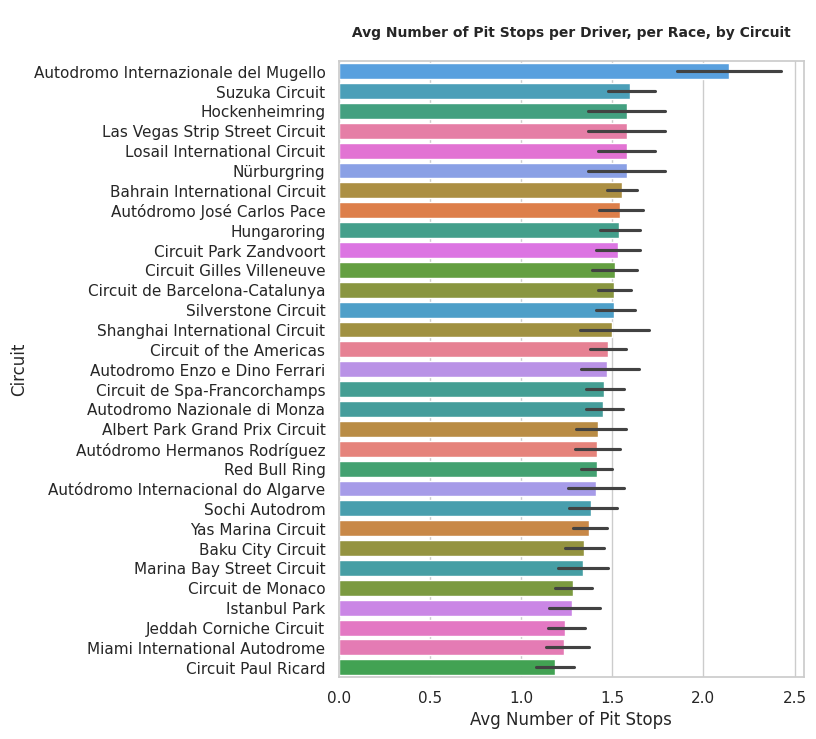

In [7]:
sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="DejaVu Sans")
ordered_circuits = PitsDF_RACE_DRIVER_LEVEL.groupby("circuit.circuitname")["Total_Num_Pits"].mean().sort_values(ascending=False).index

#Plot
fig, ax = plt.subplots(figsize=(6, 8))
sns.barplot(y="circuit.circuitname", x="Total_Num_Pits",data=PitsDF_RACE_DRIVER_LEVEL,estimator="mean",order=ordered_circuits,hue="circuit.circuitname",legend=False, ax=ax)

ax.set(ylabel="Circuit", xlabel="Avg Number of Pit Stops")
ax.set_title("\n Avg Number of Pit Stops per Driver, per Race, by Circuit \n",fontsize=10,fontweight='bold')

plt.show()


##### >>> Distributon of number of pits by season

The average number of pits per driver per season has increased each year.

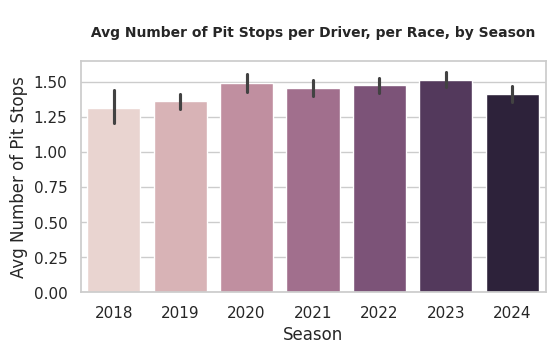

In [8]:
sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="DejaVu Sans")
ordered_circuits = PitsDF_RACE_DRIVER_LEVEL.groupby("season")["Total_Num_Pits"].mean().sort_values(ascending=False).index

#Plot
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(x="season", y="Total_Num_Pits",data=PitsDF_RACE_DRIVER_LEVEL,estimator="mean",hue="season",legend=False, ax=ax)

ax.set(xlabel="Season", ylabel="Avg Number of Pit Stops")
ax.set_title("\n Avg Number of Pit Stops per Driver, per Race, by Season \n",fontsize=10,fontweight='bold')

plt.show()

### B. How much time do they last?

Below, we can see how much time a car takes to enter the pit stop and return to the race. As expected, this duration varies significantly between circuits. We are limiting our observations to those with a duration of less than 2 minutes, as we have identified some outliers at circuits like Silverstone and Monaco. We examined a sample of these cases, and they correspond to the official times reported by the FIA. However, we have omitted these entries since some of the recorded times even exceeded the 30 minutes, which is unrealistic in the context of F1.

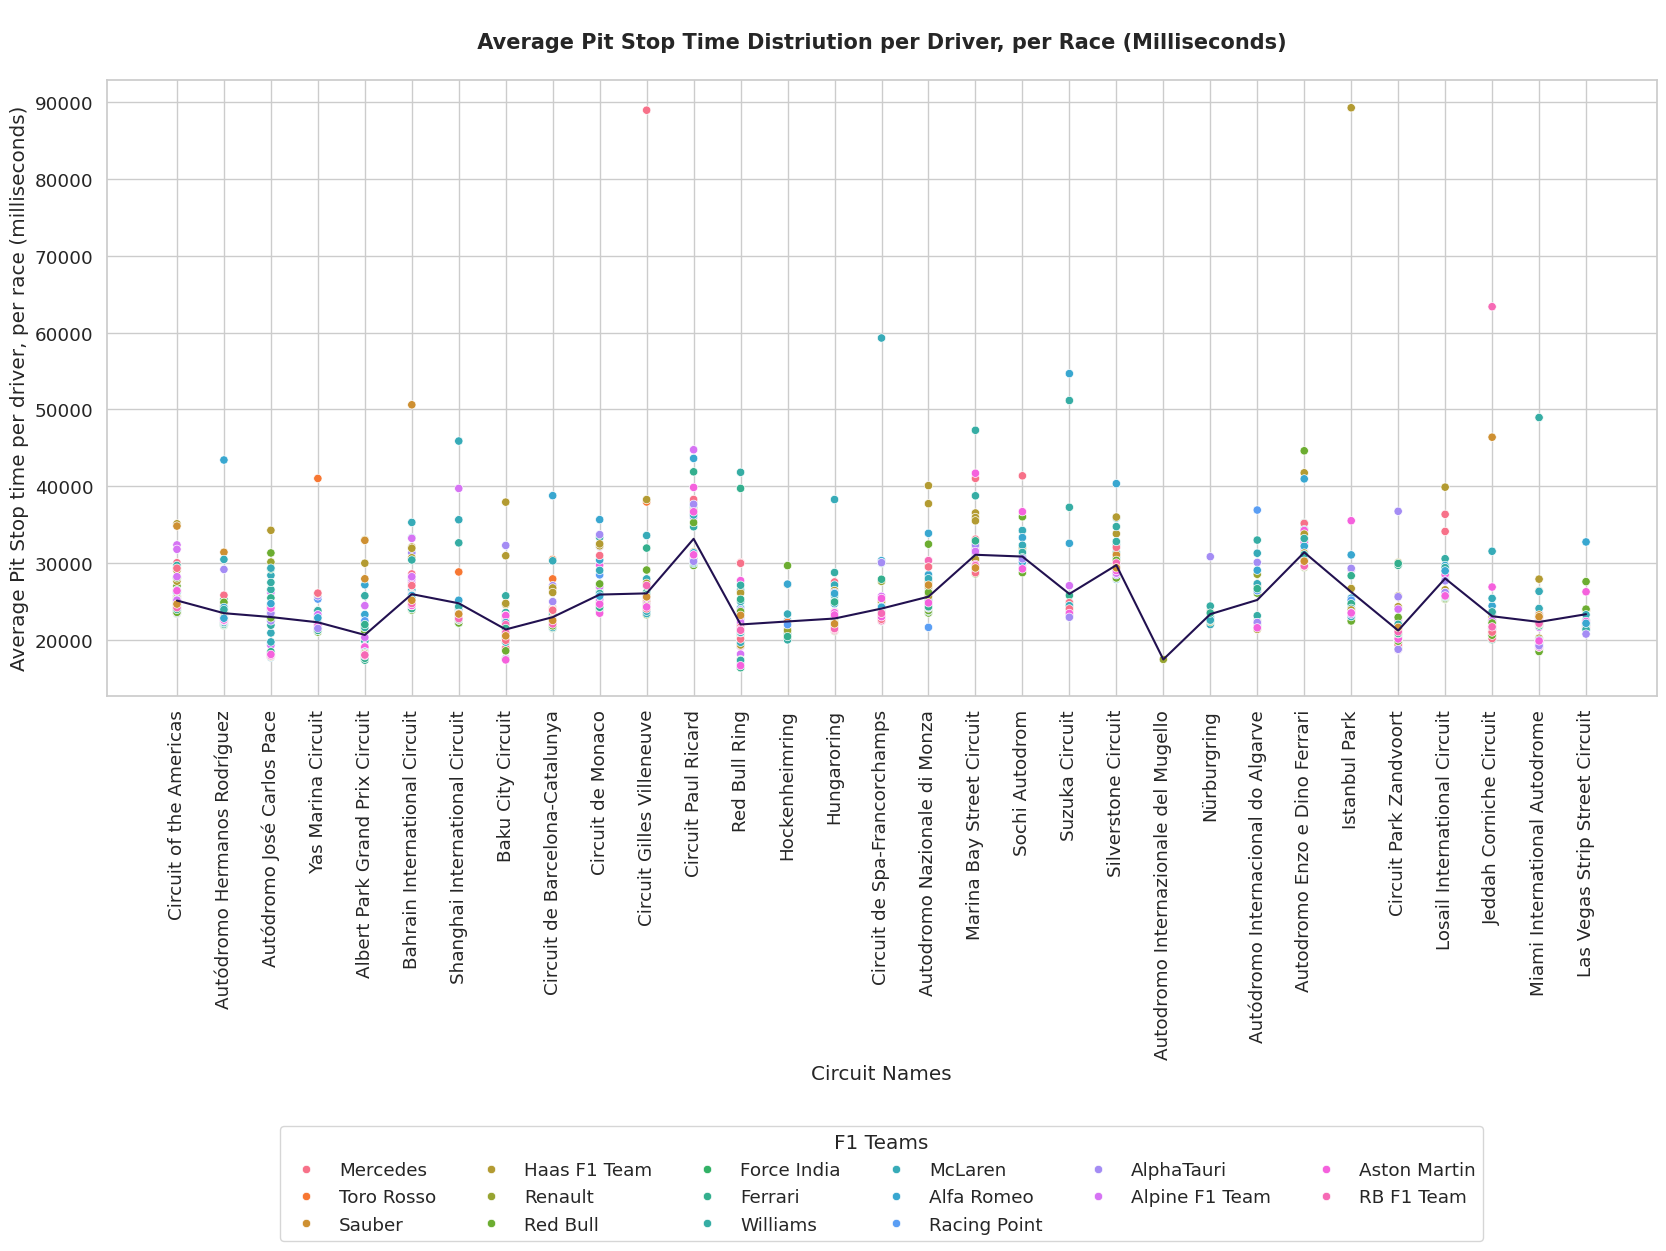

In [9]:
sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

DF=PitsDF_RACE_DRIVER_LEVEL[PitsDF_RACE_DRIVER_LEVEL["Avg_Duration_Pits_milliseconds"]<120000]

#Plot
fig, ax = plt.subplots(figsize=(20, 8))
sns.scatterplot(x="circuit.circuitname", y="Avg_Duration_Pits_milliseconds",hue='constructor.name',markers=True,data=DF)
sns.lineplot(x="circuit.circuitname", y="Avg_Duration_Pits_milliseconds",estimator="mean",ci=None,data=DF)

ax.set(xlabel="Circuit Names", ylabel="Average Pit Stop time per driver, per race (milliseconds)")
ax.set_title("\n Average Pit Stop Time Distriution per Driver, per Race (Milliseconds) \n",fontsize=15,fontweight='bold')

circuits = DF["circuit.circuitname"].unique()
ax.set_xticks(circuits)
ax.set_xticklabels(circuits, rotation=90)  
ax.locator_params(axis="x", nbins=len(circuits))

ax.legend(bbox_to_anchor=(0.5, -0.9), loc='lower center', title="F1 Teams", ncol=6)

plt.show()


### C. In which laps do they normally stop?
There's a lot of variation in when cars make their pit stops, but the first stop usually happens around lap 20, and the second one is typically around lap 35 if there's more than one. After that, for races with three or four stops, the timing gets more spread out, especially after lap 40.

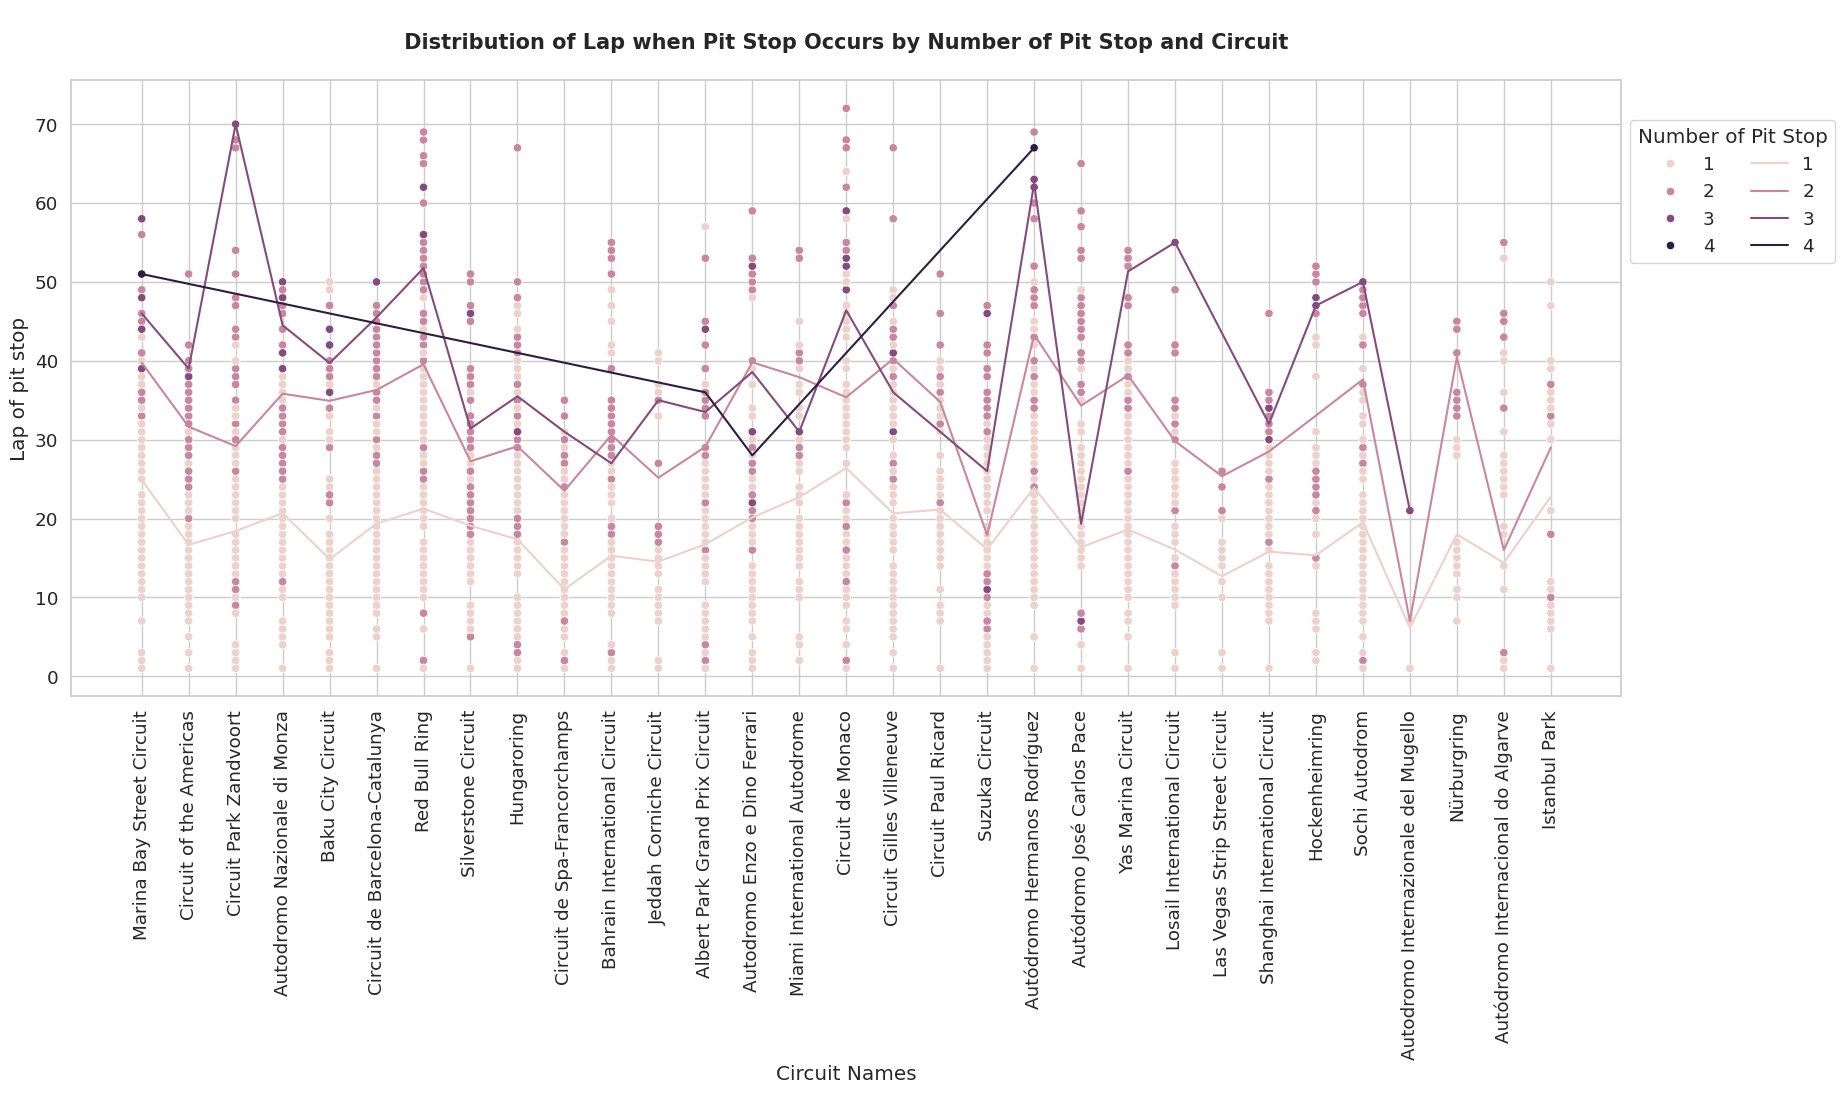

In [10]:
sns.set_theme(style="whitegrid", palette="magma",font_scale=1.2,font="DejaVu Sans")

DF=PitsDF[(PitsDF["pit_stop_duration_in_milliseconds"]<120000)]

#Plot
fig, ax = plt.subplots(figsize=(20, 8))
sns.scatterplot(x="circuit.circuitname", y="pit_stop_lap_number",hue='pit_stop_number',markers=True,data=DF)
sns.lineplot(x="circuit.circuitname", y="pit_stop_lap_number",estimator="mean",hue="pit_stop_number",ci=None,data=DF)

ax.set(xlabel="Circuit Names", ylabel="Lap of pit stop")
ax.set_title("\n Distribution of Lap when Pit Stop Occurs by Number of Pit Stop and Circuit \n",fontsize=15,fontweight='bold')

circuits = DF["circuit.circuitname"].unique()
ax.set_xticks(circuits)
ax.set_xticklabels(circuits, rotation=90)  
ax.locator_params(axis="x", nbins=len(circuits))

ax.legend(bbox_to_anchor=(1, 0.95), title="Number of Pit Stop", ncol=2)

plt.show()


### D. Number of Pit Stops in a race Distribution by the Compound use at the Start of the Race
The graphs below show that there is more likely to be more than one pit stop when having softer tyres or compounds for wet weather. The distributions for the hyper, ultra, and super soft tires are less clear, mainly due to the limited data for these compounds at the start of a race, as they were only used until the end of the 2018 season.



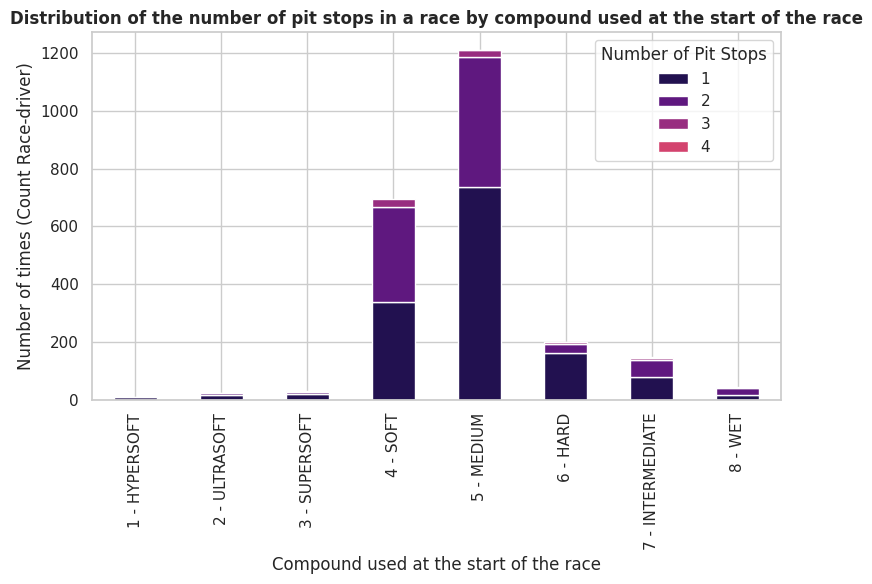

In [11]:

sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="DejaVu Sans")

DF=PitsDF_RACE_DRIVER_LEVEL.groupby(["compound_cat","compound","Total_Num_Pits"]).agg(Times=("season-round-driverid","nunique")).reset_index()
DF["N-Compound"]=DF["compound_cat"].astype("int").astype("str")+" - "+DF["compound"]

fig, ax = plt.subplots(figsize=(8, 6))

DF.pivot(index=["N-Compound"],columns="Total_Num_Pits",values="Times").fillna(0).sort_index(ascending=True).plot(kind='bar', stacked=True,ax=ax)
ax.set_title('Distribution of the number of pit stops in a race by compound used at the start of the race',fontsize=12,fontweight='bold')
ax.set_xlabel('Compound used at the start of the race')
ax.set_ylabel('Number of times (Count Race-driver)')
ax.legend(bbox_to_anchor=(1, 1), title="Number of Pit Stops", ncol=1)

plt.tight_layout()
plt.show()


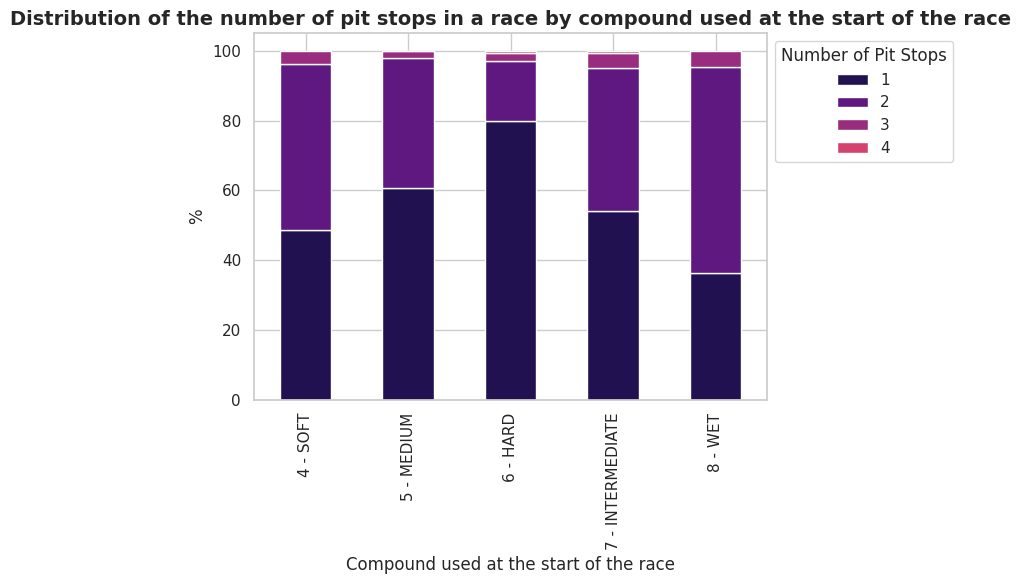

In [12]:

sns.set_theme(style="whitegrid", palette="magma",font_scale=1,font="DejaVu Sans")

DF=PitsDF_RACE_DRIVER_LEVEL[PitsDF_RACE_DRIVER_LEVEL["season"]>=2019].groupby(["compound_cat","compound","Total_Num_Pits"]).agg(Times=("season-round-driverid","nunique")).reset_index()
DF["N-Compound"]=DF["compound_cat"].astype("int").astype("str")+" - "+DF["compound"]
DF["Total_per_compound"]=DF.groupby(["N-Compound"])["Times"].transform("sum")
DF["Percentage_of_same_compound"]=DF["Times"]/DF["Total_per_compound"]*100

fig, ax = plt.subplots(figsize=(8, 6))

DF.pivot(index=["N-Compound"],columns="Total_Num_Pits",values="Percentage_of_same_compound").fillna(0).sort_index(ascending=True).plot(kind='bar', stacked=True,ax=ax)
ax.set_title('Distribution of the number of pit stops in a race by compound used at the start of the race',fontsize=14,fontweight='bold')
ax.set_xlabel('Compound used at the start of the race')
ax.set_ylabel('%')
ax.legend(bbox_to_anchor=(1, 1), title="Number of Pit Stops", ncol=1)


plt.tight_layout()
plt.show()


### E. Is there any direct correlation between the weather and the number of pit stops?
The effect of the weather on the number of pit stops is related to the compound used during the race. The correlation matrixes below show the relationship between the total number of laps and the compounds used at the start of the race, with the weather (when the race starts).

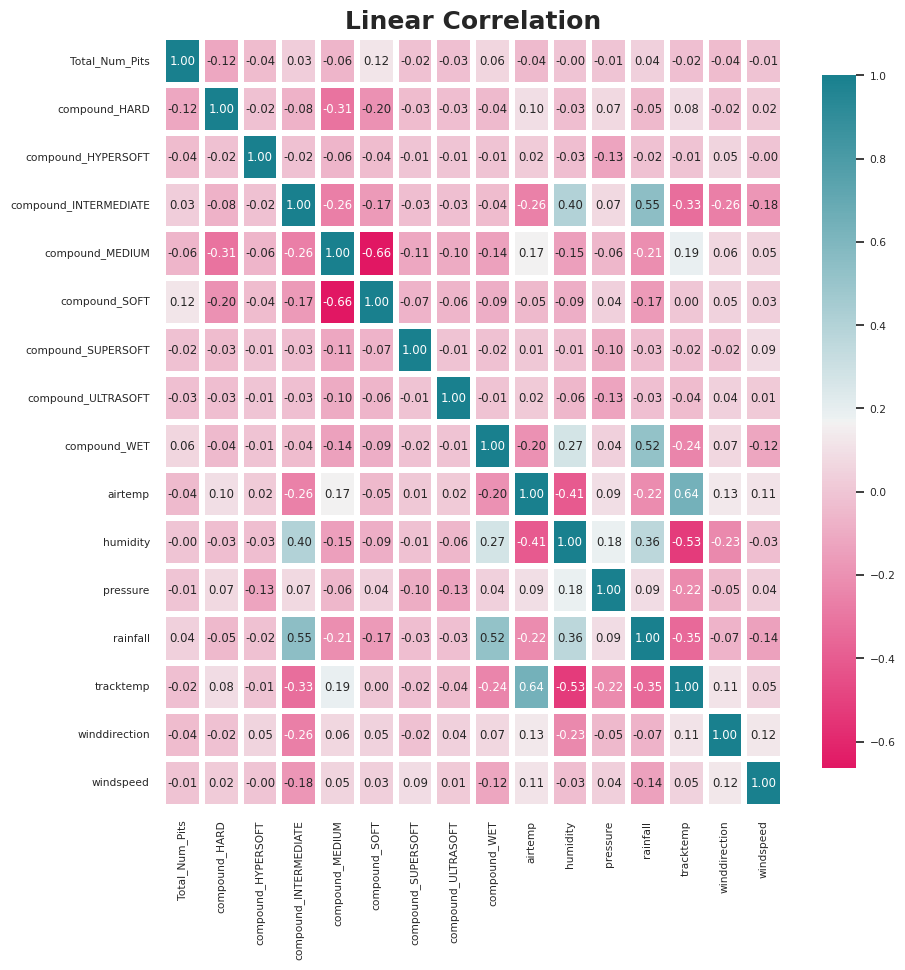

In [13]:

DF=PitsDF_RACE_DRIVER_LEVEL[["Total_Num_Pits", 'compound_HARD','compound_HYPERSOFT', 'compound_INTERMEDIATE', 'compound_MEDIUM', 'compound_SOFT', 'compound_SUPERSOFT', 'compound_ULTRASOFT', 'compound_WET',"airtemp","humidity","pressure","rainfall","tracktemp","winddirection","windspeed"]]
df_corr=DF[DF.columns].corr()

#Plot df
sns.set_theme(style="whitegrid", font_scale=0.7,font="DejaVu Sans")
fig, axs = plt.subplots(figsize=(10,10))
cmap = sns.diverging_palette(0, 210, 95, 49, as_cmap=True)
sns.heatmap(df_corr, annot=True, fmt=".2f", linewidths=3, cmap=cmap,cbar_kws={"shrink": .9},ax=axs)
axs.set_title('Linear Correlation',fontsize=18,fontweight='bold')
plt.show()
